<a href="https://colab.research.google.com/github/fjtm/clasificacion_textos/blob/master/homework_francisco_javier_tebar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de textos

Francisco Javier Tébar Martínez

14/05/2019


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import tensorflow as tf

from __future__ import print_function
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## 1 Carga de datos 

Cargamos los datos sin eliminar ningún elemento del texto.

In [2]:
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=23)

print(twenty_train.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


Separamos los datos en train (80%) y validación (20%). 

In [3]:
X_train, X_val, Y_train, Y_val = train_test_split(twenty_train.data, twenty_train.target, test_size=0.2, random_state = 23, shuffle = True)
print(len(X_train), len(X_val))

9051 2263


## 2 Procesamiento de texto

Podemos mirar uno de los textos para ver un poco como es la estructura. En general se compone de una cabezera con distintos campos, un cuerpo que puede o no contener otro mensaje al cual se está respondiente y finalmente un pie de documento con el nombre y otros datos variados. 

In [4]:
print("\n".join(X_train[1].split("\n")))

From: livesey@solntze.wpd.sgi.com (Jon Livesey)
Subject: Re: Yet more Rushdie [Re: ISLAMIC LAW]
Organization: sgi
Lines: 31
NNTP-Posting-Host: solntze.wpd.sgi.com

In article <115565@bu.edu>, jaeger@buphy.bu.edu (Gregg Jaeger) writes:
|> In article <1qi3l5$jkj@fido.asd.sgi.com> livesey@solntze.wpd.sgi.com (Jon Livesey) writes:
|> 
|> >I hope an Islamic Bank is something other than BCCI, which
|> >ripped off so many small depositors among the Muslim
|> >community in the Uk and elsewhere.
|> 
|> >jon.
|> 
|> Grow up, childish propagandist.

Gregg, I'm really sorry if having it pointed out that in practice
things aren't quite the wonderful utopia you folks seem to claim
them to be upsets you, but exactly who is being childish here is 
open to question.

BBCI was an example of an Islamically owned and operated bank -
what will someone bet me they weren't "real" Islamic owners and
operators? - and yet it actually turned out to be a long-running
and quite ruthless operation to steal money fr

Creamos varias funciones que servirán para tratar el texto. 

In [5]:
# Función que coge solamente algunas de las léneas del encabezado y elimina el 
# resto. 

def clean_head(data):  
  text_complete = []
  for j, text in enumerate(data):
    head = []
    sentence_sinal = []
    for i, sentence in enumerate(text.split("\n")):
      if sentence != "":
        if "subject" in sentence.lower():
          head.append(sentence[len("subject")::])
        if "summary" in sentence.lower():
          head.append(sentence[len("summary")::])
        if "keywords" in sentence.lower():
          head.append(sentence[len("keywords")::])
        if "organization" in sentence.lower():
          head.append(sentence[len("organization")::])
        #if "distribution" in sentence.lower():
        #  head.append(sentence[len("distribution")::])
      else:
        break
    body = text.split("\n")[i+1::]
    text_final = head + body
    text_complete.append((' ').join(text_final))
  return(text_complete)

# Función que elimina todos los e-mails. En este caso esta función no se 
# utiliza en el modelo final.

def clean_emails(text):
  text_complete = []
  for sentence in text:
    sentence_new = []
    for word in sentence.split(" "):
      if str(re.match('^[\w\.]+@([\w]+\.)+[\w]{2,4}$',word)) == "None":
        sentence_new.append(word)
      else:
        continue
    text_complete.append((' ').join(sentence_new))
  return(text_complete)

# Función que aisla todos los caracteres no alfanuméricos y los elimina. 

def remove_non_alphanumeric(text):
  text_clean = []
  for sentence in text:
    text_clean.append(re.compile('\W').sub(" ",sentence))
                      
  return(text_clean)


# Función que elimina todas las stopwords (in, on, but...)

nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
  text_clean = []
  for sentence in text:
    text_clean.append(' '.join(word for word in sentence.lower().split() if word not in STOPWORDS))
  return(text_clean)

# Función que elimina cualquier carácter remanente aislado (a, c, p...)

def remove_one_word(text):
  text_clean = []
  for sentence in text:
    text_clean.append(' '.join(word for word in sentence.split() if len(word) > 1))
  return(text_clean) 

# Función que lematiza los verbos eliminando las conjugaciones de estos.

nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatizer(text):
  text_new = []
  for sentence in text:
    sentence_new = []
    for word in sentence.split():
      sentence_new.append(WordNetLemmatizer().lemmatize(word,'v'))
    text_new.append((' ').join(sentence_new))
  return(text_new)

# Función que "normaliza" las palabras. Simplifica palabras similares como 
# (pescador, pescado, pez) tomándolas como la misma palabra. 

#from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
#porter = PorterStemmer()
stemmer = SnowballStemmer("english")
def normalize_words(text):
  text_new = []
  for sentence in text:
    sentence_new = []
    for word in sentence.split():
      #sentence_new.append(porter.stem(word))
      sentence_new.append(stemmer.stem(word))
    text_new.append((' ').join(sentence_new))
  return(text_new) 



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Encapsulamos todas las funciones anteriores en una clase para poder utilizarlas en un pipeline. 

In [0]:
class clean_text(TransformerMixin):
  
  def __init__(self):
    """
    None

    """
    
  def transform(self, X, y = None):
    X_transform = clean_head(X)
    #X_transform = clean_emails(X_transform)
    X_transform = remove_non_alphanumeric(X_transform)
    X_transform = remove_stopwords(X_transform)
    X_transform = remove_one_word(X_transform)
    X_transform = lemmatizer(X_transform)
    X_transform = normalize_words(X_transform)
    return (X_transform)   
    
  def fit(self, X, y = None):
    """
    None

    """
    return(self)

Contamos las palabras que aparecen en los documentos creando una matriz dispersa con los resultados. Posteriormente transformamos esta matriz con la función TfidfTransformer que utiliza el método TF-IDF. 

In [0]:
tf_vectorizer = CountVectorizer(stop_words='english', ngram_range = (1, 3))

## 3 Modelos

Con respecto a los modelos trabajaremos principalmente con cuatro diferentes:
  
<li>SGD (En concreto utilizaremos un modelo de SVC con la salvedad de que emplea como método de óptimización el descenso por gradiente estocástico)</li>
<li>Regresión logística</li>
<li>Multinomial Naïve Bayes</li>
<li>RNN</li>



### SGD

Creamos un pipeline con con todos los elementos del preprocesado y el modelo para utilizar posteriormente una búsqueda de hiperparámetros con GridSearchCV. En concreto los hiperparámetros que muestro en la búsqueda final son los óptimos obtenidos, ya que el tiempo de ejecuación de todos los gridsearch que he utilizado es de varias horas y para ejecutar el código completo no tiene mucho sentido repetir estas búsquedas. 

En este punto lo mejor es optimizar los hiperparámetros de los modelos y el TF-IDF simultaneamente. Sin embargo, realizando algunas pruebas y para evitar que el tiempo de búsqueda sea desmesurado, he considerado que es razonable optimizar por ún lado los parámetros del TF-IDF y posteriormente los de los modelos. 

Así buscamos en primer lugar los parámetros de TF-IDF.

In [0]:
SGD = SGDClassifier(max_iter=100, tol = None, random_state = 23)

pipeline = Pipeline(steps = [('clean_text', clean_text()),
                             ('tfidf_count', tf_vectorizer),
                             ('tfidf_transofrm', TfidfTransformer()),
                             ('SGD', SGD)])


param_Tfidf_count = {'tfidf_count__max_features' : [None],
                     'tfidf_count__max_df' : [1.0],
                     'tfidf_count__min_df' : [1]
                    }

Utilizo como métrica de entrenamiento accuracy ya que las clases están balanceadas y a priori he comprobado que los resultados son buenos. 

In [0]:
grid_search_TF_IDF = GridSearchCV(pipeline, 
                           param_grid=param_Tfidf_count,
                           n_jobs = -1,
                           scoring = 'accuracy',
                           cv = 3,
                           verbose = 1)

Buscamos los parámetros del TF-IDF.

In [10]:
%%time

model_TF_IDF = grid_search_TF_IDF.fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.4min finished


CPU times: user 1min 47s, sys: 934 ms, total: 1min 48s
Wall time: 6min 14s


Podemos ver que con solamente ejecutar los parámetros óptimos en el GridSearchCV con 3-folds, el tiempo de ejecuación está entorno a los 3-5 min. Las búsquedas que he realizado necesitaban normalmente más de 100 ajustes, lo que se traducia en más de una hora de ejecuación en la mayoría de los GridSearchCV. 

In [11]:
model_TF_IDF.best_params_

{'tfidf_count__max_df': 1.0,
 'tfidf_count__max_features': None,
 'tfidf_count__min_df': 1}

Con los parámetros obtenidos para TF-IDF, buscamos los hiperparámetros de SVC. 

In [0]:
tf_vectorizer = CountVectorizer(stop_words='english',
                                max_df = model_TF_IDF.best_params_["tfidf_count__max_df"],
                                max_features = model_TF_IDF.best_params_["tfidf_count__max_features"],
                                min_df = model_TF_IDF.best_params_["tfidf_count__min_df"],
                                ngram_range = (1, 3))

param_SVC = {'SGD__early_stopping' : [False],
                     'SGD__alpha' : [8e-5],
                     'SGD__penalty' :['l2'],
                     'SGD__max_iter' : [10]
                    }

pipeline_SVC = Pipeline(steps = [('clean_text', clean_text()),
                             ('tfidf_count', tf_vectorizer),
                             ('tfidf_transofrm', TfidfTransformer()),
                             ('SGD', SGD)])

In [0]:
grid_search_SVC = GridSearchCV(pipeline_SVC, 
                           param_grid=param_SVC,
                           n_jobs = -1,
                           scoring = 'accuracy',
                           cv = 3,
                           verbose = 1)

In [14]:
%%time

model_SVC = grid_search_SVC.fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.0min finished


CPU times: user 55.2 s, sys: 720 ms, total: 55.9 s
Wall time: 3min 57s


In [15]:
model_SVC.best_params_

{'SGD__alpha': 8e-05,
 'SGD__early_stopping': False,
 'SGD__max_iter': 10,
 'SGD__penalty': 'l2'}

### Regresión logística

De la misma manera que para SVC buscamos el hiperparámetro en este caso. 

In [0]:
lr = LogisticRegression(solver = 'liblinear')

param_lr = {'lr__C' : [90],
                    }

pipeline_lr = Pipeline(steps = [('clean_text', clean_text()),
                             ('tfidf_count', tf_vectorizer),
                             ('tfidf_transofrm', TfidfTransformer()),
                             ('lr', lr)])

grid_search_lr = GridSearchCV(pipeline_lr, 
                           param_grid=param_lr,
                           n_jobs = -1,
                           scoring = 'accuracy',
                           cv = 3,
                           verbose = 1)

In [17]:
%%time

model_lr = grid_search_lr.fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.5min finished


CPU times: user 2min 29s, sys: 1.05 s, total: 2min 30s
Wall time: 7min 58s


In [18]:
model_lr.best_params_

{'lr__C': 90}

### Multinomial Naïve Bayes

Repetimos lo mismo de los dos apartados anteriores. 

In [0]:
nb = MultinomialNB(fit_prior  = False)

param_nb = {'nb__alpha' : [1e-2],
                    }

pipeline_nb = Pipeline(steps = [('clean_text', clean_text()),
                             ('tfidf_count', tf_vectorizer),
                             ('tfidf_transofrm', TfidfTransformer()),
                             ('nb', nb)])

grid_search_nb = GridSearchCV(pipeline_nb, 
                           param_grid=param_nb,
                           n_jobs = -1,
                           scoring = 'accuracy',
                           cv = 3,
                           verbose = 1)

In [20]:
%%time

model_nb = grid_search_nb.fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.0min finished


CPU times: user 51.6 s, sys: 1.21 s, total: 52.8 s
Wall time: 3min 54s


In [21]:
model_nb.best_params_

{'nb__alpha': 0.01}

### RNN

El último modelo que he probado ha sido RNN en concreto una red formada principalmente por una LSTM. En este punto he intentado emplear una sola LSTM, dos LSTM's apiladas y LSTM's bidireccionales. Solamente muestro el primero de ellos ya que es, con diferencia, el que mejor resultados devolvía y el más rápido a la hora de entrenar. 

Adicionalmente intenté utilizar embeddings pre entrenados pero me costaba mucho conseguir que la red aprendiese y en caso de conseguirlo los resultados no eran buenos. Por ello, esta linea la he explorado muy poco. 

Lo primero es transformar el texto y las etiquétas.

In [0]:
def prepare_data_RNN(sentences, labels, maxlen, max_features, dictionary = None, train = True):
  
  # Distingue si necesita crear el diccionario en función si son datos de train o test
  
  if train:
    wordcount = dict()

    for ss in sentences:
        for w in ss.split(" "):
            if w not in wordcount:
                wordcount[w] = 1
            else:
                wordcount[w] += 1

    counts = list(wordcount.values()) 
    keys = list(wordcount) 

    sorted_idx = reversed(np.argsort(counts))

    worddict = dict()
    for idx, ss in enumerate(sorted_idx):
        worddict[keys[ss]] = idx+2  
  else:
    worddict = dictionary
    
  # Transforma las palabras a los números correspondientes asociados por el diccionario

  seqs = []
  for idx, ss in enumerate(sentences):
      seqs.append([worddict[w] if w in worddict else 1 for w in ss.split(" ")])
  
  # Permitimos solamente el número de palabras más frecuentes (con el límite mas_features)
  
  removed_seqs = [[0 if w >= max_features else w for w in sen] for sen in seqs]
  
  # Creamos los vectores con la misma longitud para el modelo RNN
  
  text_transform = tf.keras.preprocessing.sequence.pad_sequences(removed_seqs, maxlen=maxlen, padding='pre', truncating='post')
  
  # Tranformamos las etiquetas en variables categóricas. 
  
  labels_tranform = np_utils.to_categorical(labels, 20)
  
  if train:
    return worddict, text_transform, labels_tranform
  else:
    return text_transform, labels_tranform
    


In [0]:
maxlen = 100
max_features = 7000
worddict, X_train_RNN, Y_train_RNN = prepare_data_RNN(clean_text().transform(X_train), Y_train, maxlen, max_features)
X_val_RNN, Y_val_RNN = prepare_data_RNN(clean_text().transform(X_val), Y_val, maxlen, max_features, worddict, train = False)

Definimos el modelo.

In [24]:
dim_embedings = 128 
num_hidden_rnn = 128

# LAYER 1: Inputs
seq_prev_input = tf.keras.layers.Input(shape=(maxlen,), dtype='int32') 

# LAYER 2: Embeddings
embeds = tf.keras.layers.Embedding(max_features, dim_embedings)(seq_prev_input)

# LAYER 3: Spacial dropout
spaci_drop = tf.keras.layers.SpatialDropout1D(0.75)(embeds)

# LAYERS 4: RNN - forwards LSTM con dropout
droput_percent = 0.5

forward   = tf.keras.layers.LSTM(num_hidden_rnn, return_sequences=False,
                 dropout=droput_percent, recurrent_dropout=droput_percent, name='Forward')(spaci_drop)

# LAYER 5: Capa densa para los outputs - activación softmax 
output = tf.keras.layers.Dense(20, activation='softmax')(forward)

# Definimos la arquitectura
model_RNN = tf.keras.models.Model(inputs=seq_prev_input, outputs=output)
model_RNN.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 128)          896000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 128)          0         
_________________________________________________________________
Forward (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 20)                2580      
Total params: 1,030,164
Trainable params: 1,030,164
Non-trainable params: 0
___________

Compilamos el modelo con la función de pérdida categorical crossentropy y adam como optimizador. 

In [0]:
model_RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Entrenamos el modelo durante 100 epochs pero configurando una parada si en 10 epochs la función de pérdida sobre el set de validación no disminuye.  Si sucede esto se toman como mejores pesos aquellos con una menor función de perdida. 

In [26]:
%%time

batch_size = 256

model_RNN_history = model_RNN.fit(X_train_RNN, Y_train_RNN, batch_size=batch_size, epochs=100, verbose=0, validation_data=(X_val_RNN, Y_val_RNN),
                     callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=0, restore_best_weights=True)])

Instructions for updating:
Use tf.cast instead.
CPU times: user 15min 16s, sys: 1min 12s, total: 16min 29s
Wall time: 11min 13s


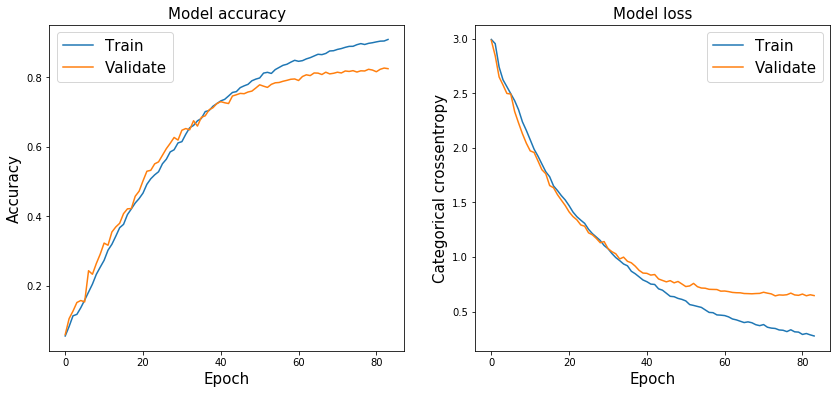

In [27]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(model_RNN_history.history['acc'])
plt.plot(model_RNN_history.history['val_acc'])
plt.title('Model accuracy', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Validate'], loc='best', fontsize = 15)

plt.subplot(122)
plt.plot(model_RNN_history.history['loss'])
plt.plot(model_RNN_history.history['val_loss'])
plt.title('Model loss', fontsize=15)
plt.ylabel('Categorical crossentropy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Validate'], loc='best', fontsize = 15)
plt.show()

Vemos que esta red consigue aproximadamente unos resultados sobre el set de validación de entorno al 80%. 

De todos los modelos que he probado modificando el número de palábras máximas a considerar, la longitud de los vectores, el tamaño de los embeddings, las diferentes arquitecturas. El mejor modelo que he obtenido ha logrado un 83% sobre el conjunto de validación con un entrenamiento de aproximadamente una hora. Como veremos a continuación, los modelos más simples como la regresión logística arrojan resultados mucho mejores y muchísimo más rápido. 

Una posibilidad por la que las RNN no funcionan tan bien como los otros modelos, es que para estas es necesario definir unos vectores del mismo tamaño para poder iniciar la red. De esta manera al tener que establecer esta longitud estamos haciendo que muchos de los e-mail que tienen muy pocas palabras o los que tienen muchas sean representados por un vector de longitud no apropiada. Con esto estamos perdiendo en muchos casos mucha información que si se tiene en cuenta al utilizar TF-IDF y los posteriores SVC, NB o LR. 

Por todo esto, creo que aunque las redes neuronales son muy potentes para muchos problemas, en este caso no son la mejor herramienta a utilizar. 

## 4 Evaluación sobre los datos de validación

Evaluemos los tres modelos SVC, Logistic Regression y Multinomial NB.

### SVC

In [0]:
SGD = SGDClassifier(tol = None,
                    alpha = model_SVC.best_params_['SGD__alpha'],
                    early_stopping = model_SVC.best_params_['SGD__early_stopping'],
                    max_iter = model_SVC.best_params_['SGD__max_iter'],
                    penalty = model_SVC.best_params_['SGD__penalty'],
                    random_state = 23)

pipeline_SVC = Pipeline(steps = [('clean_text', clean_text()),
                             ('tfidf_count', tf_vectorizer),
                             ('tfidf_transofrm', TfidfTransformer()),
                             ('SGD', SGD)])

In [29]:
%%time

model_SVC_train = pipeline_SVC.fit(X_train, Y_train)

CPU times: user 54.9 s, sys: 519 ms, total: 55.4 s
Wall time: 55.4 s


In [30]:
predict_SVC = model_SVC_train.predict(X_val)
print('Accuracy valid SVC: ', np.round(model_SVC_train.score(X_val, Y_val),3))
pd.DataFrame(confusion_matrix(Y_val, predict_SVC))

Accuracy valid SVC:  0.931


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2
1,0,103,6,1,3,3,0,0,0,0,0,1,1,0,0,0,0,0,0,0
2,1,2,101,4,0,2,2,0,0,0,0,0,0,1,0,1,0,0,0,0
3,0,2,8,91,3,3,3,1,0,0,1,0,1,0,0,1,0,0,0,0
4,1,0,1,3,112,0,4,0,0,0,0,0,1,0,0,0,0,1,0,0
5,0,3,3,1,0,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,2,3,0,0,1,95,0,0,0,1,0,4,0,0,0,1,1,0,0
7,0,1,0,0,0,1,2,121,0,0,1,0,2,0,0,0,0,0,0,0
8,0,1,0,0,0,0,2,0,124,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,1,0,121,1,1,0,0,0,0,0,0,0,0


Obtenemos un accuracy sobre los datos de validación del 93%, un resultado muchísimo mejor al obtenido por cualquier RNN que he probado. En general veo que falla mayoritariamente en algunas clases como es la 19, relacionada con temas religiosos. Es posible que este fallo se deba a que en general todas las clases tienen aproximadamente unos 600 textos, sin embargo esta última solamente tiene 19 y por tanto hay menos textos para entrenar el modelo para esta categoría. 

### Regresión logística

In [0]:
lr = LogisticRegression(C = model_lr.best_params_['lr__C'],solver = 'liblinear')

pipeline_lr = Pipeline(steps = [('clean_text', clean_text()),
                             ('tfidf_count', tf_vectorizer),
                             ('tfidf_transofrm', TfidfTransformer()),
                             ('lr', lr)])

In [32]:
%%time

model_lr_train = pipeline_lr.fit(X_train, Y_train)

CPU times: user 2min 27s, sys: 648 ms, total: 2min 28s
Wall time: 2min 28s


In [33]:
predict_lr = model_lr_train.predict(X_val)
print('Accuracy valid LR: ', np.round(model_lr_train.score(X_val, Y_val),3))
pd.DataFrame(confusion_matrix(Y_val, predict_lr))

Accuracy valid LR:  0.923


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,2
1,0,104,6,1,2,3,0,0,0,0,0,1,1,0,0,0,0,0,0,0
2,1,4,98,5,0,3,2,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,4,8,92,3,3,1,0,0,0,0,0,2,0,0,1,0,0,0,0
4,1,1,1,3,109,1,4,0,0,0,0,0,2,0,0,0,0,1,0,0
5,0,2,4,1,0,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,2,3,0,0,1,93,0,0,1,1,0,5,0,0,0,1,1,0,0
7,0,1,0,0,0,1,2,121,0,0,1,0,2,0,0,0,0,0,0,0
8,0,1,0,0,0,0,2,0,123,0,1,0,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,1,0,120,1,0,0,0,1,0,0,0,0,0


Obtenemos un resultado muy similar con la regresión logística, al obtenido con SVC. 

### Multinomial NB

In [0]:
nb = MultinomialNB(fit_prior  = False, alpha = model_nb.best_params_['nb__alpha'])

pipeline_nb = Pipeline(steps = [('clean_text', clean_text()),
                             ('tfidf_count', tf_vectorizer),
                             ('tfidf_transofrm', TfidfTransformer()),
                             ('nb', nb)])

In [35]:
%%time

model_nb_train = pipeline_nb.fit(X_train, Y_train)

CPU times: user 51.6 s, sys: 1.06 s, total: 52.7 s
Wall time: 52.7 s


In [36]:
predict_nb = model_nb_train.predict(X_val)
print('Accuracy valid NB: ', np.round(model_nb_train.score(X_val, Y_val),3))
pd.DataFrame(confusion_matrix(Y_val, predict_nb))

Accuracy valid NB:  0.922


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
1,0,101,3,2,2,7,0,1,0,0,0,0,0,1,1,0,0,0,0,0
2,0,1,93,12,0,3,2,0,0,0,1,0,0,1,0,1,0,0,0,0
3,0,2,7,92,0,1,4,1,0,0,2,1,2,0,0,2,0,0,0,0
4,1,0,1,2,112,1,3,0,1,0,0,0,1,0,0,0,0,0,1,0
5,0,1,2,0,0,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,2,2,2,3,1,85,0,1,4,2,0,2,0,2,0,1,1,0,0
7,0,1,0,0,0,0,2,120,1,0,1,0,2,0,1,0,0,0,0,0
8,0,0,0,0,0,0,1,0,125,0,0,0,0,0,1,0,0,0,0,0
9,0,1,0,0,0,0,0,2,0,116,4,0,0,0,1,0,0,0,0,0


Tenemos nuevamente un resultado similar. Sin embargo, destacar que este modelo clasifica mejor la clase 19 que es minoritaria. 

Como vemos todos los modelos obtienen un accuracy en validación muy próximo entorno a 92-93%. Puesto que todos estos modelos tienen un buen resultado, en vez de utilizar solamente uno de ellos, usaré un metamodelo de estos tres. 

La estrategia consistirá en utilizar el modelo de SVC como base, pero si los modelos NB y LR predicen los dos otra clase diferente, utilizar la predicción estos últimos. 

In [37]:
def ensemble_models(Y_real,predict_SVC, predict_lr, predict_nb):
  pred = []
  for i in range(len(Y_real)):
    if predict_nb[i] == predict_lr[i]:
      pred.append(predict_lr[i])
    else:
      pred.append(predict_SVC[i])
  acc = (pred - Y_real  == 0).sum()/len(Y_real)
  return pred, acc

pred, acc = ensemble_models(Y_val, predict_SVC, predict_lr, predict_nb)
print('Accuracy valid ensamble: ', np.round(acc,3))
pd.DataFrame(confusion_matrix(Y_val, pred))

Accuracy valid ensamble:  0.928


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2
1,0,103,6,1,3,3,0,0,0,0,0,1,1,0,0,0,0,0,0,0
2,1,2,100,5,0,2,2,0,0,0,0,0,0,1,0,1,0,0,0,0
3,0,3,7,91,3,3,3,1,0,0,1,0,1,0,0,1,0,0,0,0
4,1,0,1,3,112,0,4,0,0,0,0,0,1,0,0,0,0,1,0,0
5,0,2,3,1,0,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,2,3,0,0,1,93,0,0,1,1,0,5,0,0,0,1,1,0,0
7,0,1,0,0,0,1,2,121,0,0,1,0,2,0,0,0,0,0,0,0
8,0,1,0,0,0,0,2,0,124,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,1,0,121,1,0,0,0,1,0,0,0,0,0


En este caso no mejora el accuracy del SVC, pero creo que en general es mejor utilizar esta estrategia que involucra varios modelos y aporta algo de diversidad a los resultados. 

## 5 Evaluación sobre los datos de test

In [41]:
twenty_test = fetch_20newsgroups(subset='test',
                                 shuffle=True, random_state=23)

X_test = twenty_test.data
Y_test = twenty_test.target

len(X_test)

7532

Entrenamos los modelos anteriores con todos los datos de train disponibles (uniendo validation y train).

In [39]:
%%time

model_SVC_full = pipeline_SVC.fit(twenty_train.data, twenty_train.target)
model_lr_full = pipeline_lr.fit(twenty_train.data, twenty_train.target)
model_nb_full = pipeline_nb.fit(twenty_train.data, twenty_train.target)

CPU times: user 5min 13s, sys: 1.85 s, total: 5min 15s
Wall time: 5min 15s


Vemos el accuracy sobre test con la estrategia del metamodelo. 

In [40]:
predict_SVC_full = model_SVC_full.predict(X_test)
predict_lr_full = model_lr_full.predict(X_test)
predict_nb_full = model_nb_full.predict(X_test)

pred, acc = ensemble_models(Y_test, predict_SVC_full, predict_lr_full, predict_nb_full)
print('Accuracy test ensamble: ', np.round(acc,4))
pd.DataFrame(confusion_matrix(Y_test, pred))

Accuracy test ensamble:  0.8603


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,253,1,0,1,0,1,1,0,1,0,0,1,1,6,7,29,1,0,0,16
1,1,313,9,9,6,18,4,3,0,2,0,7,8,2,2,1,0,2,1,1
2,1,17,307,25,15,10,4,0,0,4,1,2,0,2,3,0,0,0,1,2
3,0,12,27,299,20,2,12,3,0,0,1,0,14,0,1,0,0,0,0,1
4,0,2,7,14,332,1,11,1,0,4,1,0,10,0,1,0,0,0,1,0
5,1,35,34,4,3,308,3,0,0,0,0,1,1,1,4,0,0,0,0,0
6,0,2,1,13,7,0,350,6,1,2,0,1,4,1,1,0,0,0,0,1
7,1,1,1,1,0,1,10,367,4,0,0,0,6,2,0,0,1,0,1,0
8,0,0,0,0,0,0,4,5,384,2,0,0,1,0,0,0,1,0,1,0
9,0,0,1,0,2,0,4,0,1,373,14,0,0,0,0,1,0,0,1,0


Finalmente se obtiene un 86% de acierto sobre los datos de test. Aunque es un buen resultado, teniendo en cuenta que sobre los datos de validación el accuracy era de entorno al 92% está claro que algo ha cambiado de los datos de valicación a los de test. Aquí, puede haber varias explicaciones:

<li> Puesto que el conjunto de validación tiene un tamaño mucho menor al de test, aunque el modelo falle más en algunas clases, al validar sobre pocos textos es posible que se esté sobreestimando el accuracy en validación.
  
<li> El dominio del problema ha cambiado entre los datos de train y test. En general he mirado algunos de los e-mails que fallan y no parece que la estrucutra general (quitando la gran variedad de e-mails que hay) cambie radicalmente. Así, una posibilidad es que simplemente los datos de train presenten un sesgo que los datos de test no tiene. 
  
<li> Una tercera posibilidad que he encontrado es que si nos fijamos hay 94 texto que clasifica en la categoría 16 (política sobre armas) y son textos de la categoría 18 (temas políticos variados). Al tratarse de categorías muy similares, es muy fácil que aparezcan palabras clave de ambas clases en los mismos documentos. Y por tanto al haber un mayor número de textos de la clase 16 para entrenar que de la clase 18, el modelo esté ligeramente más predispuesto a predecir esta clase. 
  
<li> Una última posibilidad de error que he encontrado es que algunos textos parecen estar mal clasificados ya que la gente abrío el hilo en una categoría que no correspondia. Y por esta misma línea alguno de los e-mails hacen referencia explícita (al contestar o por otro motivo) a e-mails de otras clases. Lo que hace muy difícil predecir la clase. 
  
En general se puede intentar mejorar el resultado quizás con un tratamiento más exhaustivo de los datos, variando modelos o intentar utilizar una métrica más balanceada por clases. Sin embargo, considero que un 86% de accuracy al tratarse de e-mails muy diversos entre sí, es un nivel de acierto relativamente bueno. Y por tanto me quedo con este modelo considerando que realiza una buena actuación.   